In [29]:
import pandas as pd
import numpy as np
import re

# Helper functions
def clean_name(name):
    return re.sub(r'\s+', ' ', name).replace('.', '').strip().lower()

def convert_minutes_to_float(minutes_str):
    if isinstance(minutes_str, float):
        return minutes_str
    try:
        minutes, seconds = map(int, str(minutes_str).split(":"))
        return minutes + seconds / 60
    except Exception:
        return np.nan

# Main function
def prepare_defensive_features(data_path, hashmap_path, min_matchup_minutes=600):
    df = pd.read_csv(data_path)
    hashmap_df = pd.read_csv(hashmap_path)

    # Step 1: Normalize player names
    df['player_name'] = (
        df['first_name'].fillna("").astype(str) + " " +
        df['family_name'].fillna("").astype(str)
    ).map(clean_name)
    hashmap_df['player_name'] = hashmap_df['PLAYER'].astype(str).map(clean_name)

    # Step 2: Filter qualified defenders
    hashmap_df['GP'] = pd.to_numeric(hashmap_df['GP'], errors='coerce').fillna(0)
    hashmap_df['MIN'] = pd.to_numeric(hashmap_df['MIN'], errors='coerce').fillna(0)
    qualified_names = hashmap_df[(hashmap_df['MIN'] > 1300)]['player_name'].unique()
    df = df[df['player_name'].isin(qualified_names)].copy()

    # Step 3: Filter by matchup minutes
    if "matchup_minutes" in df.columns:
        df["matchup_minutes"] = df["matchup_minutes"].apply(convert_minutes_to_float)
        total_minutes = df.groupby("player_name")["matchup_minutes"].sum()
        qualified_by_minutes = total_minutes[total_minutes >= min_matchup_minutes].index
        df = df[df["player_name"].isin(qualified_by_minutes)].copy()
        print(f"✅ Defenders with ≥{min_matchup_minutes} matchup minutes: {len(qualified_by_minutes)}")

    # Step 4: Convert numeric columns
    numeric_cols = [
        'matchup_field_goals_made', 'matchup_field_goals_attempted',
        'matchup_three_pointers_made', 'matchup_three_pointers_attempted',
        'matchup_free_throws_made', 'matchup_free_throws_attempted',
        'matchup_turnovers', 'matchup_blocks', 'help_blocks',
        'help_field_goals_made', 'help_field_goals_attempted',
        'shooting_fouls', 'matchup_minutes_sort', 'matchup_minutes', 'player_points'
    ]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
        else:
            print(f"⚠️ Warning: Column {col} missing.")

    # Step 5: Merge offensive rating data
    off = pd.read_csv("2024_offensive_advanced_metrics.csv")
    off['player_name'] = (off['first_name'].astype(str) + " " + off['last_name'].astype(str)).map(clean_name)

    df['matchup_player'] = (
        df['matchups_first_name'].astype(str) + " " + df['matchups_family_name'].astype(str)
    ).map(clean_name)

    df = df.merge(off[['player_name', 'OFFRTG']], left_on='matchup_player', right_on='player_name', how='left')
    df = df.rename(columns={'OFFRTG': 'offensive_rating'})
    df = df[df['offensive_rating'].notna()].copy()  # drop matchups with no offensive rating

    # Step 6: Engineered Features
    df["minutes_played"] = df["matchup_minutes_sort"] / 60
    df["matchup_two_pointers_made"] = df["matchup_field_goals_made"] - df["matchup_three_pointers_made"]
    df["matchup_two_pointers_attempted"] = df["matchup_field_goals_attempted"] - df["matchup_three_pointers_attempted"]

    df["efg_allowed"] = np.where(
        df["matchup_field_goals_attempted"] > 0,
        (df["matchup_field_goals_made"] + 0.5 * df["matchup_three_pointers_made"]) / df["matchup_field_goals_attempted"],
        0
    )

    df["two_pt_allowed_pct"] = np.where(
        df["matchup_two_pointers_attempted"] > 0,
        df["matchup_two_pointers_made"] / df["matchup_two_pointers_attempted"],
        0
    )

    df["turnover_rate"] = np.where(
        df.get("partial_possessions", 0) > 0,
        df["matchup_turnovers"] / df["partial_possessions"],
        0
    )

    df["block_rate"] = np.where(
        df.get("partial_possessions", 0) > 0,
        df["matchup_blocks"] / df["partial_possessions"],
        0
    )

    df["help_stop_rate"] = np.where(
        df["help_field_goals_attempted"] > 0,
        1 - df["help_field_goals_made"] / df["help_field_goals_attempted"],
        0
    )

    df["coverage_share"] = df.get("percentage_defender_total_time", 0)
    df["points_allowed_per_100"] = np.where(
        df.get("partial_possessions", 0) > 0,
        df["player_points"] / df["partial_possessions"] * 100,
        0
    )

    df["fga_per_min"] = np.where(df["matchup_minutes"] > 0,
        df["matchup_field_goals_attempted"] / df["matchup_minutes"],
        0
    )

    df["3pa_per_min"] = np.where(df["matchup_minutes"] > 0,
        df["matchup_three_pointers_attempted"] / df["matchup_minutes"],
        0
    )

    df["fta_per_min"] = np.where(df["matchup_minutes"] > 0,
        df["matchup_free_throws_attempted"] / df["matchup_minutes"],
        0
    )

    df["switch_rate"] = np.where(
        df.get("matchup_minutes", 0) > 0,
        df.get("switches_on", 0) / df["matchup_minutes"],
        0
    )

    return df.reset_index(drop=True)

In [33]:
# Ensure the function is defined before using it

# Ensure the function is defined before using it

features_from_2024_season_df = prepare_defensive_features(data_path="matchups_2024 2.csv", hashmap_path="2024_Player_Hashmap.csv")

# Check if 'first_name' exists in the DataFrame
if 'first_name' not in features_from_2024_season_df.columns:
	features_from_2024_season_df['first_name'] = None  # Add a placeholder column if missing

# Convert 'matchup_minutes_sort' to float and assign to 'matchup_minutes'
features_from_2024_season_df['matchup_minutes'] = features_from_2024_season_df['matchup_minutes_sort'].apply(convert_minutes_to_float)

features_from_2024_season_df

✅ Defenders with ≥600 matchup minutes: 141


KeyError: 'first_name'

✅ Defenders with ≥600 matchup minutes: 141
[0]	validation_0-logloss:0.60223
[1]	validation_0-logloss:0.57228
[2]	validation_0-logloss:0.54501
[3]	validation_0-logloss:0.51546
[4]	validation_0-logloss:0.49258
[5]	validation_0-logloss:0.46308
[6]	validation_0-logloss:0.44552
[7]	validation_0-logloss:0.42768
[8]	validation_0-logloss:0.40404
[9]	validation_0-logloss:0.38877
[10]	validation_0-logloss:0.36756
[11]	validation_0-logloss:0.34801
[12]	validation_0-logloss:0.33535
[13]	validation_0-logloss:0.31802
[14]	validation_0-logloss:0.30196
[15]	validation_0-logloss:0.28946
[16]	validation_0-logloss:0.27548
[17]	validation_0-logloss:0.26483
[18]	validation_0-logloss:0.25500
[19]	validation_0-logloss:0.24321
[20]	validation_0-logloss:0.23965
[21]	validation_0-logloss:0.23474
[22]	validation_0-logloss:0.22409
[23]	validation_0-logloss:0.21631
[24]	validation_0-logloss:0.20672
[25]	validation_0-logloss:0.19774
[26]	validation_0-logloss:0.19330
[27]	validation_0-logloss:0.19042
[28]	validation

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:43:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[145]	validation_0-logloss:0.02042
[146]	validation_0-logloss:0.02018
[147]	validation_0-logloss:0.01994
[148]	validation_0-logloss:0.01966
[149]	validation_0-logloss:0.01943
[150]	validation_0-logloss:0.01921
[151]	validation_0-logloss:0.01895
[152]	validation_0-logloss:0.01886
[153]	validation_0-logloss:0.01869
[154]	validation_0-logloss:0.01849
[155]	validation_0-logloss:0.01842
[156]	validation_0-logloss:0.01823
[157]	validation_0-logloss:0.01799
[158]	validation_0-logloss:0.01782
[159]	validation_0-logloss:0.01764
[160]	validation_0-logloss:0.01749
[161]	validation_0-logloss:0.01728
[162]	validation_0-logloss:0.01721
[163]	validation_0-logloss:0.01700
[164]	validation_0-logloss:0.01682
[165]	validation_0-logloss:0.01663
[166]	validation_0-logloss:0.01647
[167]	validation_0-logloss:0.01629
[168]	validation_0-logloss:0.01617
[169]	validation_0-logloss:0.01600
[170]	validation_0-logloss:0.01587
[171]	validation_0-logloss:0.01572
[172]	validation_0-logloss:0.01561
[173]	validation_0-l

<Figure size 1000x600 with 0 Axes>

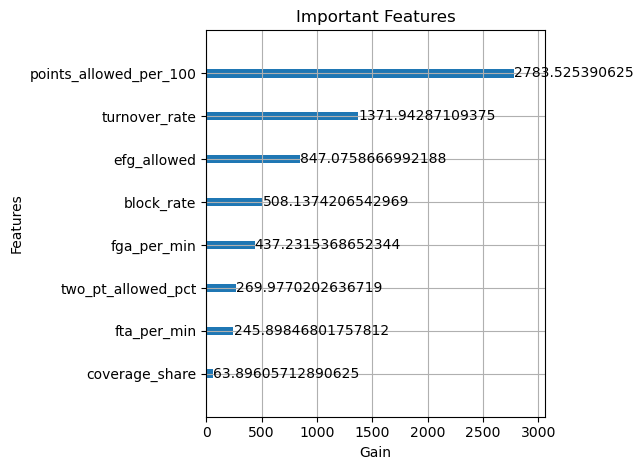

Generating SHAP values...


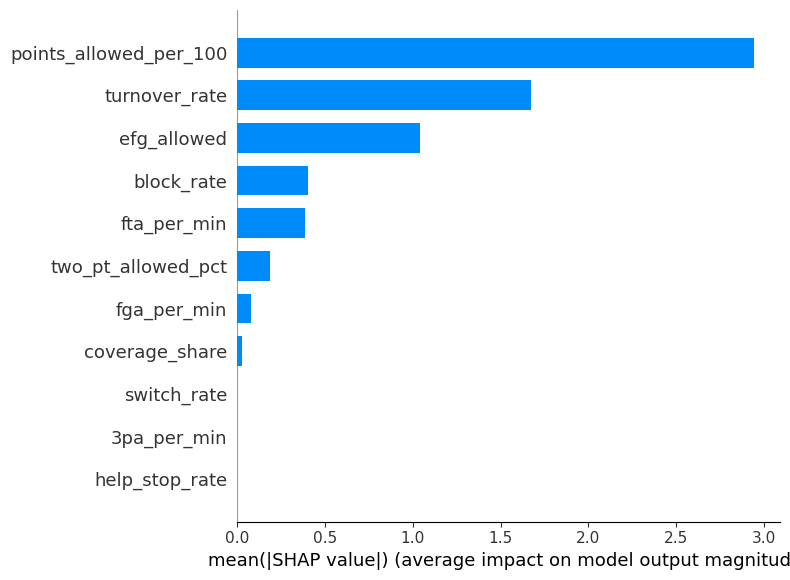

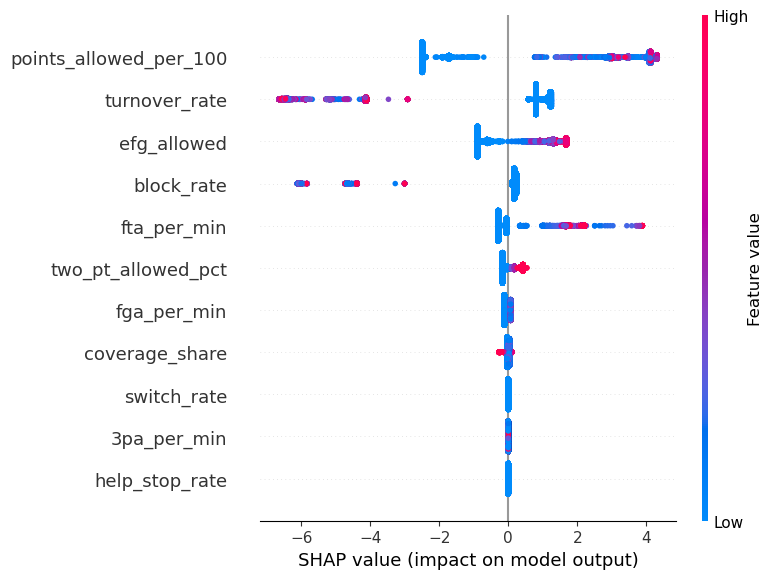


Top Defenders by Average Scoring Probability:


first_name,family_name,position,avg_scoring_probability,possessions
Nickeil,Alexander-Walker,F,0.001252,787
Mikal,Bridges,F,0.106296,773
Josh,Green,G,0.129951,631
Dillon,Brooks,G,0.154741,699
Draymond,Green,F,0.173875,622
Dorian,Finney-Smith,G,0.200848,594
Ochai,Agbaji,G,0.200890,595
Josh,Green,F,0.202483,631
Draymond,Green,C,0.206069,622
Haywood,Highsmith,F,0.207606,646


In [ ]:
%matplotlib inline

import pandas as pd 
import numpy as np 
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split 
from sklearn.metrics import log_loss, roc_auc_score 
from sklearn.calibration import CalibratedClassifierCV
from IPython.display import display, HTML
import shap
import matplotlib.pyplot as plt

# -----------------------------------------------
# Define scoring event outside model function
def derive_scoring_event(row): 
    help_fga = row.get("help_field_goals_attempted", 0)
    help_fgm = row.get("help_field_goals_made", 0)
    help_stop = (help_fga > 0 and help_fgm == 0)

    defensive_stop = (
        row.get("matchup_turnovers", 0) > 0 or
        row.get("help_blocks", 0) > 0 or
        row.get("matchup_blocks", 0) > 0 or
        help_stop or
        (
            row.get("matchup_field_goals_made", 0) == 0 and
            row.get("matchup_free_throws_made", 0) == 0 and 
            row.get("shooting_fouls", 0) == 0
        )
    )
    return 0 if defensive_stop else 1

# Drop leaky features
def filter_non_leaky_features(X):
    leaky_keywords = [
    'matchup_field_goals_made', 'matchup_field_goals_attempted',
    'matchup_three_pointers_made', 'matchup_three_pointers_attempted',
    'matchup_free_throws_made', 'matchup_free_throws_attempted',
    'matchup_turnovers', 'matchup_blocks', 'help_blocks',
    'help_field_goals_made', 'help_field_goals_attempted',
    'shooting_fouls', 'points', 'allowed', 'stop', 'rate'
    ]
    def is_leaky(col): return any(kw in col.lower() for kw in leaky_keywords)
    safe_cols = [col for col in X.columns if not is_leaky(col)]
    return X[safe_cols].copy()

# -----------------------------------------------
# Model training function (X, y, metadata passed in)
def train_defensive_classifier_with_logic(X, y, metadata, test_size=0.2, random_state=42):
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    # Train classifier
    model = XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=2,
        subsample=0.6,
        colsample_bytree=0.6,
        reg_alpha=6.0,
        reg_lambda=7.0,
        random_state=random_state,
        n_jobs=-1,
        tree_method='hist',
        eval_metric='logloss',
        use_label_encoder=False,
        objective='binary:logistic'
    )

    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)
    calibrated_model = CalibratedClassifierCV(model, method = 'sigmoid', cv = 'prefit')
    calibrated_model.fit(X_train, y_train)

    # Evaluate
    y_pred_proba = calibrated_model.predict_proba(X_test)[:, 1]
    print("\n Model Trained:")
    print(f"Log Loss: {log_loss(y_test, y_pred_proba):.4f}")
    print(f"AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

    # Feature importance
    plt.figure(figsize=(10, 6))
    plot_importance(model, max_num_features=15, importance_type='gain', title='Important Features', xlabel='Gain')
    plt.tight_layout()
    plt.show()

    # SHAP interpretability
    print("Generating SHAP values...")
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=True)
    shap.summary_plot(shap_values, X_test, show=True)

    # Defender-level scoring probability (lower is better)
    metadata = metadata.loc[X.index].copy()
    metadata["scoring_probability"] = calibrated_model.predict_proba(X)[:, 1]

    defender_scores_df = (
        metadata.groupby(['person_id', 'first_name', 'family_name', 'position'])['scoring_probability']
        .mean()
        .reset_index()
        .rename(columns={'scoring_probability': 'avg_scoring_probability'})
    )

    defender_possessions = metadata.groupby('person_id').size().reset_index(name='possessions')
    defender_scores_df = defender_scores_df.merge(defender_possessions, on='person_id', how='left')

    defender_scores_df = defender_scores_df.sort_values(by='avg_scoring_probability')

    print("\nTop Defenders by Average Scoring Probability:")
    display(HTML(defender_scores_df[['first_name', 'family_name', 'position', 'avg_scoring_probability', 'possessions']]
                 .head(200)
                 .to_html(index=False)))

    # Return the required values
    return model, defender_scores_df, shap_values, X_test, y_test

# -----------------------------------------------
# RUN THE PIPELINE

# Load and clean full dataset
cleaned_df = prepare_defensive_features(
    data_path="matchups_2024 2.csv",
    hashmap_path="2024_Player_Hashmap.csv",
    min_matchup_minutes=600
)

# Label the cleaned data
cleaned_df['scoring_event'] = cleaned_df.apply(derive_scoring_event, axis=1)

# Now define X
feature_cols = [
    'efg_allowed','two_pt_allowed_pct','turnover_rate','block_rate',
    'help_stop_rate','coverage_share','points_allowed_per_100',
    'fga_per_min','3pa_per_min','fta_per_min','switch_rate',
]

X = cleaned_df[feature_cols].copy()
y = cleaned_df['scoring_event']

# Train the model
model, defender_scores_df, shap_values, X_test, y_test = train_defensive_classifier_with_logic(X, y, cleaned_df)
